## Pitch Names Classifier

In [1]:
import numpy as np

from htm.bindings.sdr import SDR
from htm.bindings.encoders import ScalarEncoder, ScalarEncoderParameters
from htm.algorithms import SpatialPooler as SP
from htm.algorithms import TemporalMemory as TM
from htm.bindings.algorithms import Classifier

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
%matplotlib inline

In [2]:
pitchNames = ("C","D","E","F","G","A","B")

scalarEncoderParams = ScalarEncoderParameters()
scalarEncoderParams.minimum = 0
scalarEncoderParams.maximum = 6
scalarEncoderParams.activeBits = 3
scalarEncoderParams.category = True

enc = ScalarEncoder(scalarEncoderParams)

print ("C: ", enc.encode(0))
print ("D: ", enc.encode(1))
print ("E: ", enc.encode(2))
print ("F: ", enc.encode(3))
print ("G: ", enc.encode(4))
print ("A: ", enc.encode(5))
print ("B: ", enc.encode(6))

C:  SDR( 21 ) 0, 1, 2
D:  SDR( 21 ) 3, 4, 5
E:  SDR( 21 ) 6, 7, 8
F:  SDR( 21 ) 9, 10, 11
G:  SDR( 21 ) 12, 13, 14
A:  SDR( 21 ) 15, 16, 17
B:  SDR( 21 ) 18, 19, 20


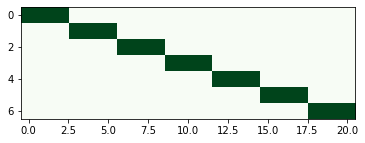

In [3]:
n_samples = int(enc.parameters.maximum - enc.parameters.minimum + 1)

sdrs = []
for i in np.linspace(enc.parameters.minimum, enc.parameters.maximum, n_samples):
  sdrs.append( enc.encode( i ).dense )

plt.imshow(np.array(sdrs), cmap = "Greens")
plt.show()

In [4]:
inputSDR  = SDR( dimensions = (21, ) )
activeSDR = SDR( dimensions = (576,) )
sp = SP(inputDimensions  = inputSDR.dimensions,
        columnDimensions = activeSDR.dimensions,
        localAreaDensity = 0.02,
        globalInhibition = True,
        seed             = 1,
        synPermActiveInc   = 0.01,
        synPermInactiveDec = 0.008)

print(sp)

Spatial Pooler Connections:
    Inputs (21) ~> Outputs (576) via Segments (576)
    Segments on Cell Min/Mean/Max 1 / 1 / 1
    Potential Synapses on Segment Min/Mean/Max 11 / 11 / 11
    Connected Synapses on Segment Min/Mean/Max 1 / 5.44097 / 10
    Synapses Dead (0%) Saturated (0%)
    Synapses pruned (0%) Segments pruned (0%)



In [5]:
clsr = Classifier()

In [6]:
tm = TM(
    columnDimensions = (576,),
    cellsPerColumn=11,
    initialPermanence=0.5,
    connectedPermanence=0.5,
    minThreshold=8,
    maxNewSynapseCount=20,
    permanenceIncrement=0.1,
    permanenceDecrement=0.0,
    activationThreshold=8,
)
print(tm)

Temporal Memory Connections:
    Inputs (0) ~> Outputs (6336) via Segments (0)
    Segments on Cell Min/Mean/Max 0 / 0 / 0
    Potential Synapses on Segment Min/Mean/Max 4294967295 / nan / 0
    Connected Synapses on Segment Min/Mean/Max 65535 / nan / 0
    Synapses Dead (nan%) Saturated (nan%)
    Synapses pruned (nan%) Segments pruned (nan%)



input SDR:  SDR( 21 ) 0, 1, 2
Active SDR:  SDR( 576 ) 62, 113, 121, 222, 243, 320, 409, 453, 478, 567, 572
Classifier learn:  0



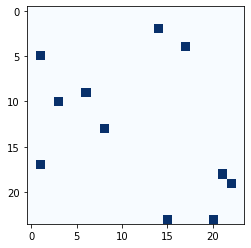

SDR( 576, 11 ) 1089, 1672, 3267, 4092, 5335, 5786, 5907, 6072, 6105, 6204, 6325

input SDR:  SDR( 21 ) 3, 4, 5
Active SDR:  SDR( 576 ) 99, 152, 297, 372, 485, 526, 537, 552, 555, 564, 575
Classifier learn:  1



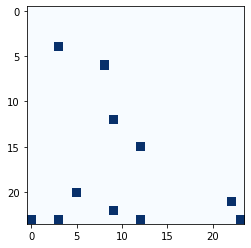

SDR( 576, 11 ) 737, 1133, 2013, 4840, 5885, 5962, 5995, 6006, 6017, 6138, 6281, 6303

input SDR:  SDR( 21 ) 6, 7, 8
Active SDR:  SDR( 576 ) 67, 103, 183, 440, 535, 542, 545, 546, 547, 558, 571
Classifier learn:  2



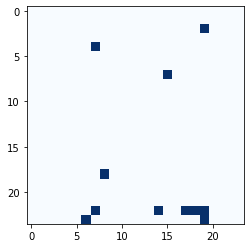

SDR( 576, 11 ) 605, 1914, 2794, 3146, 3443, 3740, 4070, 4554, 5643, 5984, 6215

input SDR:  SDR( 21 ) 9, 10, 11
Active SDR:  SDR( 576 ) 55, 174, 254, 286, 313, 340, 370, 414, 513, 544, 565
Classifier learn:  3



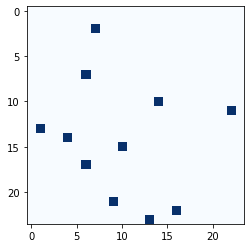

SDR( 576, 11 ) 429, 660, 759, 2321, 4202, 5599, 5753, 5940, 6073, 6116, 6304

input SDR:  SDR( 21 ) 12, 13, 14
Active SDR:  SDR( 576 ) 39, 60, 69, 211, 382, 509, 523, 540, 552, 556, 573
Classifier learn:  4



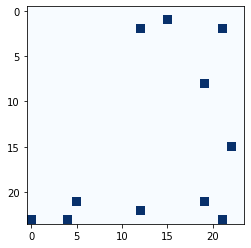

SDR( 576, 11 ) 781, 1320, 1859, 2266, 2398, 2981, 3432, 3444, 3696, 4631, 6305

input SDR:  SDR( 21 ) 15, 16, 17
Active SDR:  SDR( 576 ) 71, 120, 169, 206, 218, 271, 312, 313, 336, 421, 573
Classifier learn:  5



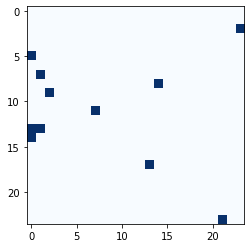

SDR( 576, 11 ) 517, 1045, 1122, 1232, 2255, 2717, 3410, 3982, 4543, 5500, 6326

input SDR:  SDR( 21 ) 18, 19, 20
Active SDR:  SDR( 576 ) 47, 95, 102, 112, 205, 247, 310, 362, 413, 500, 575
Classifier learn:  6



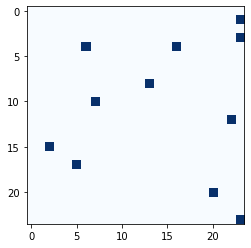

SDR( 576, 11 ) 682, 1243, 1331, 2442, 2673, 3520, 4499, 4983, 5258, 6237, 6292

input SDR:  SDR( 21 ) 0, 1, 2
Active SDR:  SDR( 576 ) 62, 113, 121, 222, 243, 320, 409, 453, 478, 567, 572
Classifier learn:  0



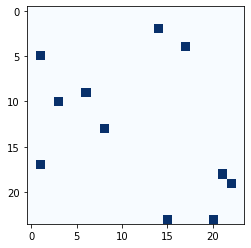

SDR( 576, 11 ) 1089, 1672, 3267, 4092, 5335, 5786, 5907, 6072, 6105, 6204, 6325

input SDR:  SDR( 21 ) 3, 4, 5
Active SDR:  SDR( 576 ) 99, 152, 297, 372, 485, 526, 537, 552, 555, 564, 575
Classifier learn:  1



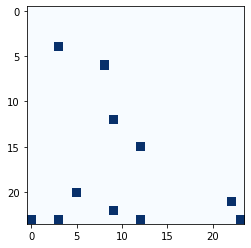

SDR( 576, 11 ) 737, 1133, 2013, 4840, 5885, 5962, 5995, 6006, 6017, 6138, 6281, 6303

input SDR:  SDR( 21 ) 6, 7, 8
Active SDR:  SDR( 576 ) 67, 103, 183, 440, 535, 542, 545, 546, 547, 558, 571
Classifier learn:  2



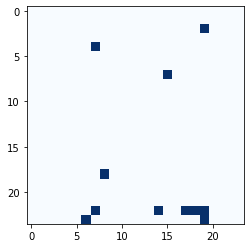

SDR( 576, 11 ) 605, 1914, 2794, 3146, 3443, 3740, 4070, 4554, 5643, 5984, 6215

input SDR:  SDR( 21 ) 9, 10, 11
Active SDR:  SDR( 576 ) 55, 174, 254, 286, 313, 340, 370, 414, 513, 544, 565
Classifier learn:  3



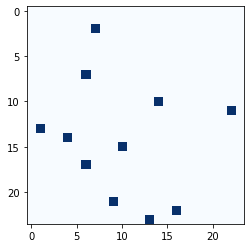

SDR( 576, 11 ) 429, 660, 759, 2321, 4202, 5599, 5753, 5940, 6073, 6116, 6304

input SDR:  SDR( 21 ) 12, 13, 14
Active SDR:  SDR( 576 ) 39, 60, 69, 211, 382, 509, 523, 540, 552, 556, 573
Classifier learn:  4



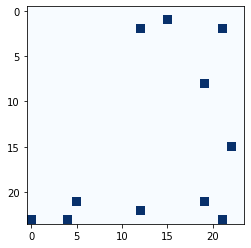

SDR( 576, 11 ) 781, 1320, 1859, 2266, 2398, 2981, 3432, 3444, 3696, 4631, 6305

input SDR:  SDR( 21 ) 15, 16, 17
Active SDR:  SDR( 576 ) 71, 120, 169, 206, 218, 271, 312, 313, 336, 421, 573
Classifier learn:  5



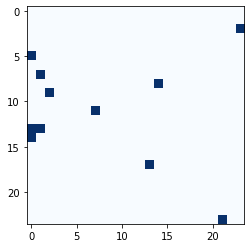

SDR( 576, 11 ) 517, 1045, 1122, 1232, 2255, 2717, 3410, 3982, 4543, 5500, 6326

input SDR:  SDR( 21 ) 18, 19, 20
Active SDR:  SDR( 576 ) 47, 95, 102, 112, 205, 247, 310, 362, 413, 500, 575
Classifier learn:  6



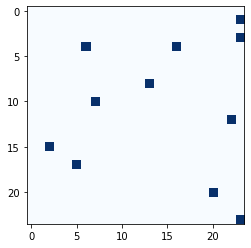

SDR( 576, 11 ) 682, 1243, 1331, 2442, 2673, 3520, 4499, 4983, 5258, 6237, 6292

input SDR:  SDR( 21 ) 0, 1, 2
Active SDR:  SDR( 576 ) 62, 113, 121, 222, 243, 320, 409, 453, 478, 567, 572
Classifier learn:  0



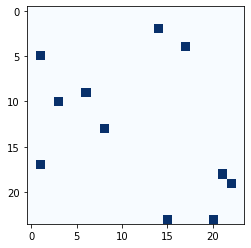

SDR( 576, 11 ) 1089, 1672, 3267, 4092, 5335, 5786, 5907, 6072, 6105, 6204, 6325

input SDR:  SDR( 21 ) 3, 4, 5
Active SDR:  SDR( 576 ) 99, 152, 297, 372, 485, 526, 537, 552, 555, 564, 575
Classifier learn:  1



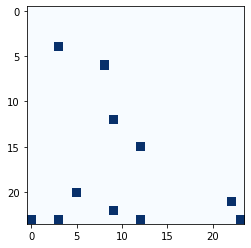

SDR( 576, 11 ) 737, 1133, 2013, 4840, 5885, 5962, 5995, 6006, 6017, 6138, 6281, 6303

input SDR:  SDR( 21 ) 6, 7, 8
Active SDR:  SDR( 576 ) 67, 103, 183, 440, 535, 542, 545, 546, 547, 558, 571
Classifier learn:  2



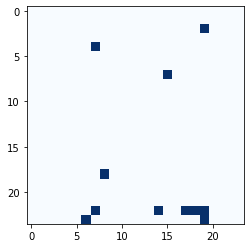

SDR( 576, 11 ) 605, 1914, 2794, 3146, 3443, 3740, 4070, 4554, 5643, 5984, 6215

input SDR:  SDR( 21 ) 9, 10, 11
Active SDR:  SDR( 576 ) 55, 174, 254, 286, 313, 340, 370, 414, 513, 544, 565
Classifier learn:  3



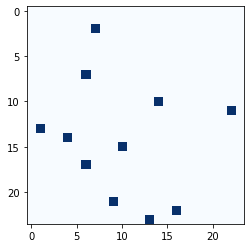

SDR( 576, 11 ) 429, 660, 759, 2321, 4202, 5599, 5753, 5940, 6073, 6116, 6304

input SDR:  SDR( 21 ) 12, 13, 14
Active SDR:  SDR( 576 ) 39, 60, 69, 211, 382, 509, 523, 540, 552, 556, 573
Classifier learn:  4



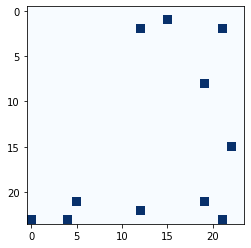

SDR( 576, 11 ) 781, 1320, 1859, 2266, 2398, 2981, 3432, 3444, 3696, 4631, 6305

input SDR:  SDR( 21 ) 15, 16, 17
Active SDR:  SDR( 576 ) 71, 120, 169, 206, 218, 271, 312, 313, 336, 421, 573
Classifier learn:  5



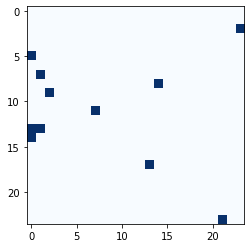

SDR( 576, 11 ) 517, 1045, 1122, 1232, 2255, 2717, 3410, 3982, 4543, 5500, 6326

input SDR:  SDR( 21 ) 18, 19, 20
Active SDR:  SDR( 576 ) 47, 95, 102, 112, 205, 247, 310, 362, 413, 500, 575
Classifier learn:  6



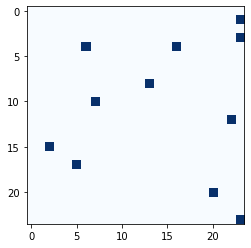

SDR( 576, 11 ) 682, 1243, 1331, 2442, 2673, 3520, 4499, 4983, 5258, 6237, 6292

input SDR:  SDR( 21 ) 0, 1, 2
Active SDR:  SDR( 576 ) 62, 113, 121, 222, 243, 320, 409, 453, 478, 567, 572
Classifier learn:  0



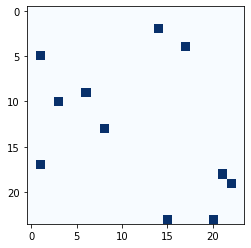

SDR( 576, 11 ) 1089, 1672, 3267, 4092, 5335, 5786, 5907, 6072, 6105, 6204, 6325

input SDR:  SDR( 21 ) 3, 4, 5
Active SDR:  SDR( 576 ) 99, 152, 297, 372, 485, 526, 537, 552, 555, 564, 575
Classifier learn:  1



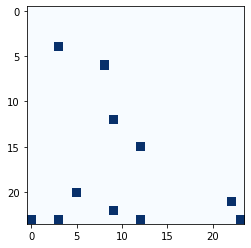

SDR( 576, 11 ) 737, 1133, 2013, 4840, 5885, 5962, 5995, 6006, 6017, 6138, 6281, 6303

input SDR:  SDR( 21 ) 6, 7, 8
Active SDR:  SDR( 576 ) 67, 103, 183, 440, 535, 542, 545, 546, 547, 558, 571
Classifier learn:  2



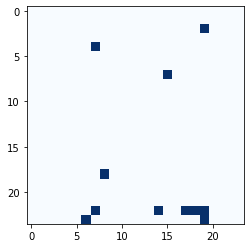

SDR( 576, 11 ) 605, 1914, 2794, 3146, 3443, 3740, 4070, 4554, 5643, 5984, 6215

input SDR:  SDR( 21 ) 9, 10, 11
Active SDR:  SDR( 576 ) 55, 174, 254, 286, 313, 340, 370, 414, 513, 544, 565
Classifier learn:  3



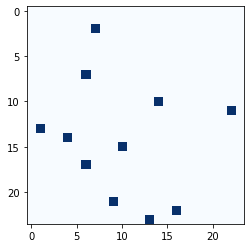

SDR( 576, 11 ) 429, 660, 759, 2321, 4202, 5599, 5753, 5940, 6073, 6116, 6304

input SDR:  SDR( 21 ) 12, 13, 14
Active SDR:  SDR( 576 ) 39, 60, 69, 211, 382, 509, 523, 540, 552, 556, 573
Classifier learn:  4



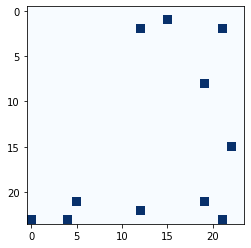

SDR( 576, 11 ) 781, 1320, 1859, 2266, 2398, 2981, 3432, 3444, 3696, 4631, 6305

input SDR:  SDR( 21 ) 15, 16, 17
Active SDR:  SDR( 576 ) 71, 120, 169, 206, 218, 271, 312, 313, 336, 421, 573
Classifier learn:  5



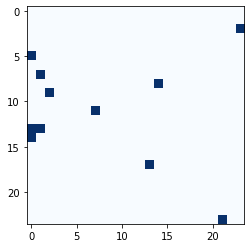

SDR( 576, 11 ) 517, 1045, 1122, 1232, 2255, 2717, 3410, 3982, 4543, 5500, 6326

input SDR:  SDR( 21 ) 18, 19, 20
Active SDR:  SDR( 576 ) 47, 95, 102, 112, 205, 247, 310, 362, 413, 500, 575
Classifier learn:  6



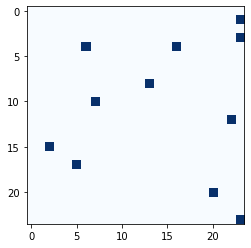

SDR( 576, 11 ) 682, 1243, 1331, 2442, 2673, 3520, 4499, 4983, 5258, 6237, 6292

input SDR:  SDR( 21 ) 0, 1, 2
Active SDR:  SDR( 576 ) 62, 113, 121, 222, 243, 320, 409, 453, 478, 567, 572
Classifier learn:  0



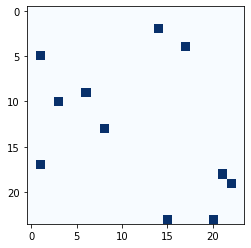

SDR( 576, 11 ) 1089, 1672, 3267, 4092, 5335, 5786, 5907, 6072, 6105, 6204, 6325

input SDR:  SDR( 21 ) 3, 4, 5
Active SDR:  SDR( 576 ) 99, 152, 297, 372, 485, 526, 537, 552, 555, 564, 575
Classifier learn:  1



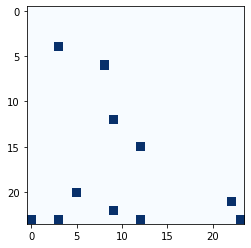

SDR( 576, 11 ) 737, 1133, 2013, 4840, 5885, 5962, 5995, 6006, 6017, 6138, 6281, 6303

input SDR:  SDR( 21 ) 6, 7, 8
Active SDR:  SDR( 576 ) 67, 103, 183, 440, 535, 542, 545, 546, 547, 558, 571
Classifier learn:  2



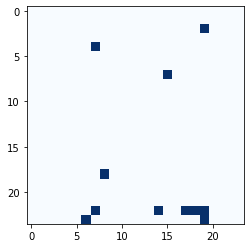

SDR( 576, 11 ) 605, 1914, 2794, 3146, 3443, 3740, 4070, 4554, 5643, 5984, 6215

input SDR:  SDR( 21 ) 9, 10, 11
Active SDR:  SDR( 576 ) 55, 174, 254, 286, 313, 340, 370, 414, 513, 544, 565
Classifier learn:  3



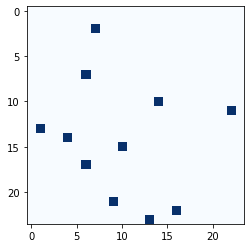

SDR( 576, 11 ) 429, 660, 759, 2321, 4202, 5599, 5753, 5940, 6073, 6116, 6304

input SDR:  SDR( 21 ) 12, 13, 14
Active SDR:  SDR( 576 ) 39, 60, 69, 211, 382, 509, 523, 540, 552, 556, 573
Classifier learn:  4



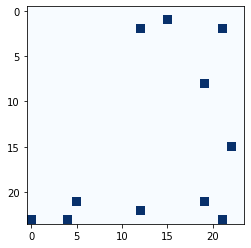

SDR( 576, 11 ) 781, 1320, 1859, 2266, 2398, 2981, 3432, 3444, 3696, 4631, 6305

input SDR:  SDR( 21 ) 15, 16, 17
Active SDR:  SDR( 576 ) 71, 120, 169, 206, 218, 271, 312, 313, 336, 421, 573
Classifier learn:  5



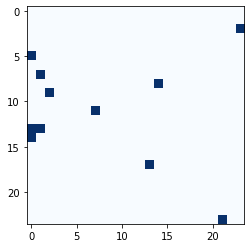

SDR( 576, 11 ) 517, 1045, 1122, 1232, 2255, 2717, 3410, 3982, 4543, 5500, 6326

input SDR:  SDR( 21 ) 18, 19, 20
Active SDR:  SDR( 576 ) 47, 95, 102, 112, 205, 247, 310, 362, 413, 500, 575
Classifier learn:  6



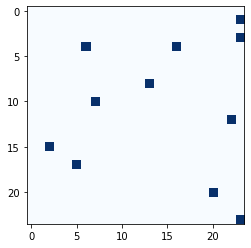

SDR( 576, 11 ) 682, 1243, 1331, 2442, 2673, 3520, 4499, 4983, 5258, 6237, 6292

input SDR:  SDR( 21 ) 0, 1, 2
Active SDR:  SDR( 576 ) 62, 113, 121, 222, 243, 320, 409, 453, 478, 567, 572
Classifier learn:  0



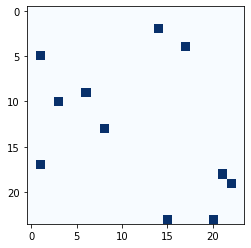

SDR( 576, 11 ) 1089, 1672, 3267, 4092, 5335, 5786, 5907, 6072, 6105, 6204, 6325

input SDR:  SDR( 21 ) 3, 4, 5
Active SDR:  SDR( 576 ) 99, 152, 297, 372, 485, 526, 537, 552, 555, 564, 575
Classifier learn:  1



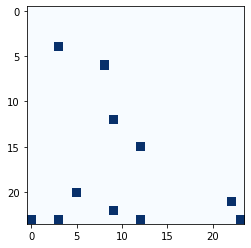

SDR( 576, 11 ) 737, 1133, 2013, 4840, 5885, 5962, 5995, 6006, 6017, 6138, 6281, 6303

input SDR:  SDR( 21 ) 6, 7, 8
Active SDR:  SDR( 576 ) 67, 103, 183, 440, 535, 542, 545, 546, 547, 558, 571
Classifier learn:  2



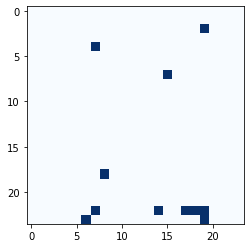

SDR( 576, 11 ) 605, 1914, 2794, 3146, 3443, 3740, 4070, 4554, 5643, 5984, 6215

input SDR:  SDR( 21 ) 9, 10, 11
Active SDR:  SDR( 576 ) 55, 174, 254, 286, 313, 340, 370, 414, 513, 544, 565
Classifier learn:  3



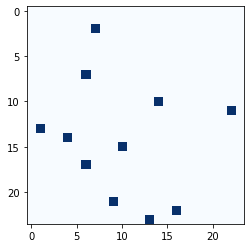

SDR( 576, 11 ) 429, 660, 759, 2321, 4202, 5599, 5753, 5940, 6073, 6116, 6304

input SDR:  SDR( 21 ) 12, 13, 14
Active SDR:  SDR( 576 ) 39, 60, 69, 211, 382, 509, 523, 540, 552, 556, 573
Classifier learn:  4



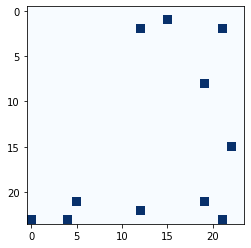

SDR( 576, 11 ) 781, 1320, 1859, 2266, 2398, 2981, 3432, 3444, 3696, 4631, 6305

input SDR:  SDR( 21 ) 15, 16, 17
Active SDR:  SDR( 576 ) 71, 120, 169, 206, 218, 271, 312, 313, 336, 421, 573
Classifier learn:  5



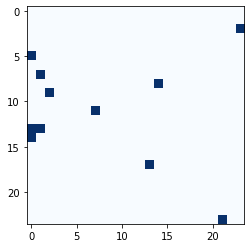

SDR( 576, 11 ) 517, 1045, 1122, 1232, 2255, 2717, 3410, 3982, 4543, 5500, 6326

input SDR:  SDR( 21 ) 18, 19, 20
Active SDR:  SDR( 576 ) 47, 95, 102, 112, 205, 247, 310, 362, 413, 500, 575
Classifier learn:  6



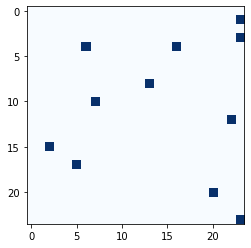

SDR( 576, 11 ) 682, 1243, 1331, 2442, 2673, 3520, 4499, 4983, 5258, 6237, 6292

input SDR:  SDR( 21 ) 0, 1, 2
Active SDR:  SDR( 576 ) 62, 113, 121, 222, 243, 320, 409, 453, 478, 567, 572
Classifier learn:  0



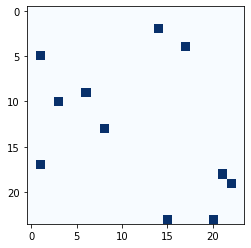

SDR( 576, 11 ) 1089, 1672, 3267, 4092, 5335, 5786, 5907, 6072, 6105, 6204, 6325

input SDR:  SDR( 21 ) 3, 4, 5
Active SDR:  SDR( 576 ) 99, 152, 297, 372, 485, 526, 537, 552, 555, 564, 575
Classifier learn:  1



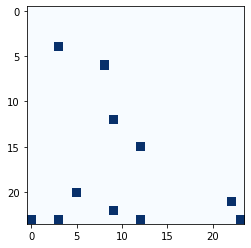

SDR( 576, 11 ) 737, 1133, 2013, 4840, 5885, 5962, 5995, 6006, 6017, 6138, 6281, 6303

input SDR:  SDR( 21 ) 6, 7, 8
Active SDR:  SDR( 576 ) 67, 103, 183, 440, 535, 542, 545, 546, 547, 558, 571
Classifier learn:  2



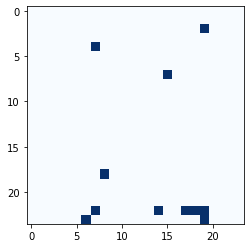

SDR( 576, 11 ) 605, 1914, 2794, 3146, 3443, 3740, 4070, 4554, 5643, 5984, 6215

input SDR:  SDR( 21 ) 9, 10, 11
Active SDR:  SDR( 576 ) 55, 174, 254, 286, 313, 340, 370, 414, 513, 544, 565
Classifier learn:  3



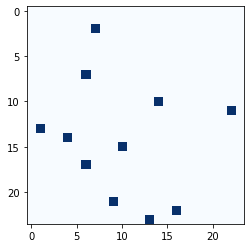

SDR( 576, 11 ) 429, 660, 759, 2321, 4202, 5599, 5753, 5940, 6073, 6116, 6304

input SDR:  SDR( 21 ) 12, 13, 14
Active SDR:  SDR( 576 ) 39, 60, 69, 211, 382, 509, 523, 540, 552, 556, 573
Classifier learn:  4



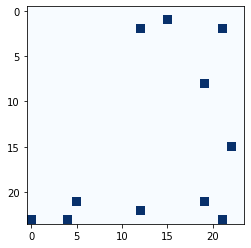

SDR( 576, 11 ) 781, 1320, 1859, 2266, 2398, 2981, 3432, 3444, 3696, 4631, 6305

input SDR:  SDR( 21 ) 15, 16, 17
Active SDR:  SDR( 576 ) 71, 120, 169, 206, 218, 271, 312, 313, 336, 421, 573
Classifier learn:  5



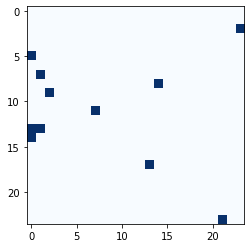

SDR( 576, 11 ) 517, 1045, 1122, 1232, 2255, 2717, 3410, 3982, 4543, 5500, 6326

input SDR:  SDR( 21 ) 18, 19, 20
Active SDR:  SDR( 576 ) 47, 95, 102, 112, 205, 247, 310, 362, 413, 500, 575
Classifier learn:  6



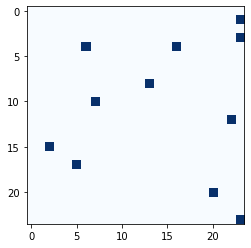

SDR( 576, 11 ) 682, 1243, 1331, 2442, 2673, 3520, 4499, 4983, 5258, 6237, 6292

input SDR:  SDR( 21 ) 0, 1, 2
Active SDR:  SDR( 576 ) 62, 113, 121, 222, 243, 320, 409, 453, 478, 567, 572
Classifier learn:  0



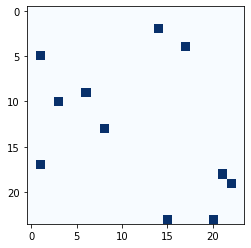

SDR( 576, 11 ) 1089, 1672, 3267, 4092, 5335, 5786, 5907, 6072, 6105, 6204, 6325

input SDR:  SDR( 21 ) 3, 4, 5
Active SDR:  SDR( 576 ) 99, 152, 297, 372, 485, 526, 537, 552, 555, 564, 575
Classifier learn:  1



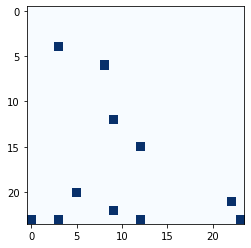

SDR( 576, 11 ) 737, 1133, 2013, 4840, 5885, 5962, 5995, 6006, 6017, 6138, 6281, 6303

input SDR:  SDR( 21 ) 6, 7, 8
Active SDR:  SDR( 576 ) 67, 103, 183, 440, 535, 542, 545, 546, 547, 558, 571
Classifier learn:  2



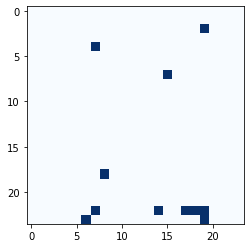

SDR( 576, 11 ) 605, 1914, 2794, 3146, 3443, 3740, 4070, 4554, 5643, 5984, 6215

input SDR:  SDR( 21 ) 9, 10, 11
Active SDR:  SDR( 576 ) 55, 174, 254, 286, 313, 340, 370, 414, 513, 544, 565
Classifier learn:  3



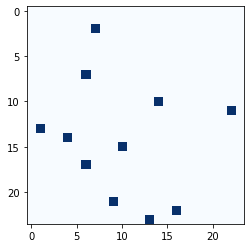

SDR( 576, 11 ) 429, 660, 759, 2321, 4202, 5599, 5753, 5940, 6073, 6116, 6304

input SDR:  SDR( 21 ) 12, 13, 14
Active SDR:  SDR( 576 ) 39, 60, 69, 211, 382, 509, 523, 540, 552, 556, 573
Classifier learn:  4



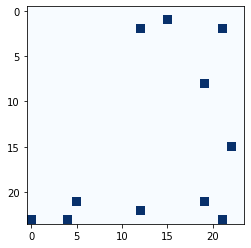

SDR( 576, 11 ) 781, 1320, 1859, 2266, 2398, 2981, 3432, 3444, 3696, 4631, 6305

input SDR:  SDR( 21 ) 15, 16, 17
Active SDR:  SDR( 576 ) 71, 120, 169, 206, 218, 271, 312, 313, 336, 421, 573
Classifier learn:  5



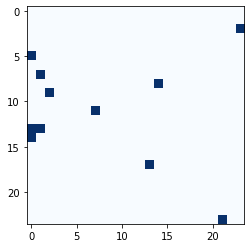

SDR( 576, 11 ) 517, 1045, 1122, 1232, 2255, 2717, 3410, 3982, 4543, 5500, 6326

input SDR:  SDR( 21 ) 18, 19, 20
Active SDR:  SDR( 576 ) 47, 95, 102, 112, 205, 247, 310, 362, 413, 500, 575
Classifier learn:  6



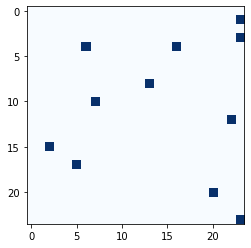

SDR( 576, 11 ) 682, 1243, 1331, 2442, 2673, 3520, 4499, 4983, 5258, 6237, 6292

input SDR:  SDR( 21 ) 0, 1, 2
Active SDR:  SDR( 576 ) 62, 113, 121, 222, 243, 320, 409, 453, 478, 567, 572
Classifier learn:  0



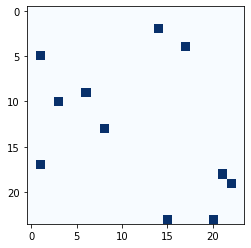

SDR( 576, 11 ) 1089, 1672, 3267, 4092, 5335, 5786, 5907, 6072, 6105, 6204, 6325

input SDR:  SDR( 21 ) 3, 4, 5
Active SDR:  SDR( 576 ) 99, 152, 297, 372, 485, 526, 537, 552, 555, 564, 575
Classifier learn:  1



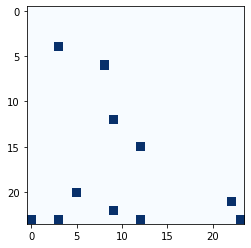

SDR( 576, 11 ) 737, 1133, 2013, 4840, 5885, 5962, 5995, 6006, 6017, 6138, 6281, 6303

input SDR:  SDR( 21 ) 6, 7, 8
Active SDR:  SDR( 576 ) 67, 103, 183, 440, 535, 542, 545, 546, 547, 558, 571
Classifier learn:  2



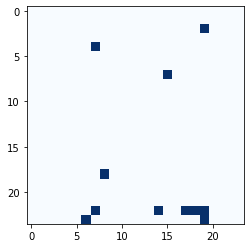

SDR( 576, 11 ) 605, 1914, 2794, 3146, 3443, 3740, 4070, 4554, 5643, 5984, 6215

input SDR:  SDR( 21 ) 9, 10, 11
Active SDR:  SDR( 576 ) 55, 174, 254, 286, 313, 340, 370, 414, 513, 544, 565
Classifier learn:  3



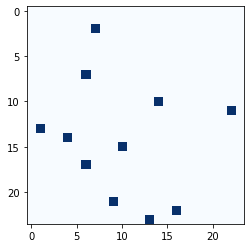

SDR( 576, 11 ) 429, 660, 759, 2321, 4202, 5599, 5753, 5940, 6073, 6116, 6304

input SDR:  SDR( 21 ) 12, 13, 14
Active SDR:  SDR( 576 ) 39, 60, 69, 211, 382, 509, 523, 540, 552, 556, 573
Classifier learn:  4



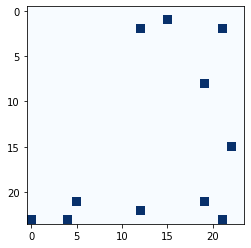

SDR( 576, 11 ) 781, 1320, 1859, 2266, 2398, 2981, 3432, 3444, 3696, 4631, 6305

input SDR:  SDR( 21 ) 15, 16, 17
Active SDR:  SDR( 576 ) 71, 120, 169, 206, 218, 271, 312, 313, 336, 421, 573
Classifier learn:  5



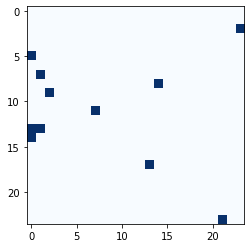

SDR( 576, 11 ) 517, 1045, 1122, 1232, 2255, 2717, 3410, 3982, 4543, 5500, 6326

input SDR:  SDR( 21 ) 18, 19, 20
Active SDR:  SDR( 576 ) 47, 95, 102, 112, 205, 247, 310, 362, 413, 500, 575
Classifier learn:  6



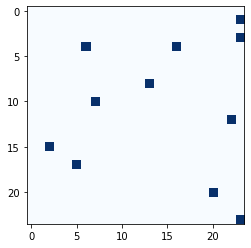

SDR( 576, 11 ) 682, 1243, 1331, 2442, 2673, 3520, 4499, 4983, 5258, 6237, 6292

input SDR:  SDR( 21 ) 0, 1, 2
Active SDR:  SDR( 576 ) 62, 113, 121, 222, 243, 320, 409, 453, 478, 567, 572
Classifier learn:  0



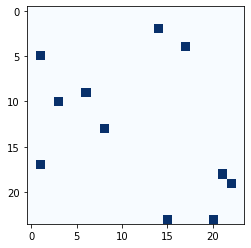

SDR( 576, 11 ) 1089, 1672, 3267, 4092, 5335, 5786, 5907, 6072, 6105, 6204, 6325

input SDR:  SDR( 21 ) 3, 4, 5
Active SDR:  SDR( 576 ) 99, 152, 297, 372, 485, 526, 537, 552, 555, 564, 575
Classifier learn:  1



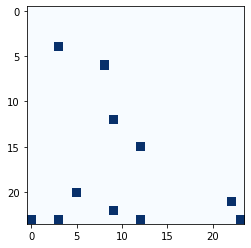

SDR( 576, 11 ) 737, 1133, 2013, 4840, 5885, 5962, 5995, 6006, 6017, 6138, 6281, 6303

input SDR:  SDR( 21 ) 6, 7, 8
Active SDR:  SDR( 576 ) 67, 103, 183, 440, 535, 542, 545, 546, 547, 558, 571
Classifier learn:  2



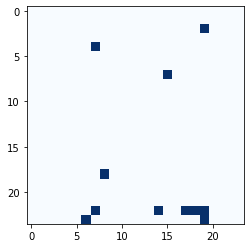

SDR( 576, 11 ) 605, 1914, 2794, 3146, 3443, 3740, 4070, 4554, 5643, 5984, 6215

input SDR:  SDR( 21 ) 9, 10, 11
Active SDR:  SDR( 576 ) 55, 174, 254, 286, 313, 340, 370, 414, 513, 544, 565
Classifier learn:  3



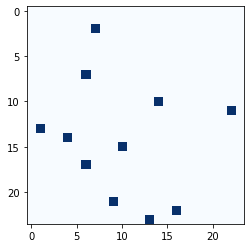

SDR( 576, 11 ) 429, 660, 759, 2321, 4202, 5599, 5753, 5940, 6073, 6116, 6304

input SDR:  SDR( 21 ) 12, 13, 14
Active SDR:  SDR( 576 ) 39, 60, 69, 211, 382, 509, 523, 540, 552, 556, 573
Classifier learn:  4



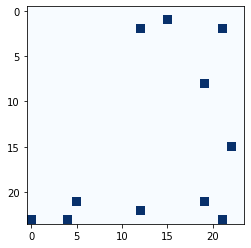

SDR( 576, 11 ) 781, 1320, 1859, 2266, 2398, 2981, 3432, 3444, 3696, 4631, 6305

input SDR:  SDR( 21 ) 15, 16, 17
Active SDR:  SDR( 576 ) 71, 120, 169, 206, 218, 271, 312, 313, 336, 421, 573
Classifier learn:  5



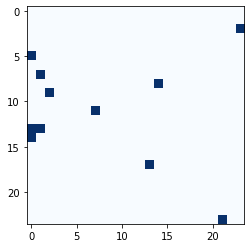

SDR( 576, 11 ) 517, 1045, 1122, 1232, 2255, 2717, 3410, 3982, 4543, 5500, 6326

input SDR:  SDR( 21 ) 18, 19, 20
Active SDR:  SDR( 576 ) 47, 95, 102, 112, 205, 247, 310, 362, 413, 500, 575
Classifier learn:  6



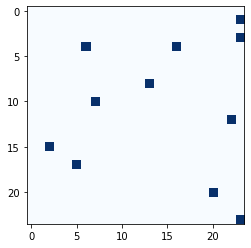

SDR( 576, 11 ) 682, 1243, 1331, 2442, 2673, 3520, 4499, 4983, 5258, 6237, 6292

Temporal Memory Connections:
    Inputs (89) ~> Outputs (6336) via Segments (78)
    Segments on Cell Min/Mean/Max 0 / 0.0123106 / 1
    Potential Synapses on Segment Min/Mean/Max 11 / 12.4103 / 20
    Connected Synapses on Segment Min/Mean/Max 11 / 12.4103 / 20
    Synapses Dead (0%) Saturated (0.897727%)
    Synapses pruned (0%) Segments pruned (0%)



In [15]:
batch=10
for n in range(batch):    
    for i in range(len(pitchNames)):
        inputSDR = enc.encode(i)
        print("input SDR: ",inputSDR)
        sp.compute(inputSDR, True, activeSDR)
        print("Active SDR: ",activeSDR)
        clsr.learn( activeSDR, i )
        print("Classifier learn: ",i)
        print("")

        #clear_output(wait = True)
        #plt.cla
        sampleSDR=activeSDR.dense.reshape(24,24)
        plt.imshow(sampleSDR, cmap = "Blues")
        plt.pause(0.01)

        tm.compute( activeSDR, learn=True)
        tm.activateDendrites(True)
        print(tm.getPredictiveCells())
        print("")
print(tm)

---  0  ---
input SDR:  SDR( 21 ) 0, 1, 2
Active SDR:  SDR( 576 ) 62, 113, 121, 222, 243, 320, 409, 453, 478, 567, 572


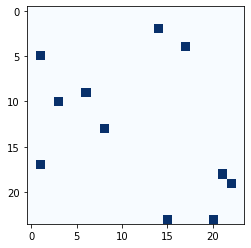

SDR( 576, 11 ) 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 1243, 1244, 1245, 1246, 1247, 1248, 1249, 1250, 1251, 1252, 1253, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 2442, 2443, 2444, 2445, 2446, 2447, 2448, 2449, 2450, 2451, 2452, 2673, 2674, 2675, 2676, 2677, 2678, 2679, 2680, 2681, 2682, 2683, 3520, 3521, 3522, 3523, 3524, 3525, 3526, 3527, 3528, 3529, 3530, 4499, 4500, 4501, 4502, 4503, 4504, 4505, 4506, 4507, 4508, 4509, 4983, 4984, 4985, 4986, 4987, 4988, 4989, 4990, 4991, 4992, 4993, 5258, 5259, 5260, 5261, 5262, 5263, 5264, 5265, 5266, 5267, 5268, 6237, 6238, 6239, 6240, 6241, 6242, 6243, 6244, 6245, 6246, 6247, 6292, 6293, 6294, 6295, 6296, 6297, 6298, 6299, 6300, 6301, 6302
SDR( 576, 11 ) 1089, 1672, 3267, 4092, 5335, 5786, 5907, 6072, 6105, 6204, 6325
----------------------------------------------------------------------
Active sdr:  SDR( 576 ) 62, 113, 121, 222, 243, 320, 409, 453, 478, 567, 572
-------------------------------------------

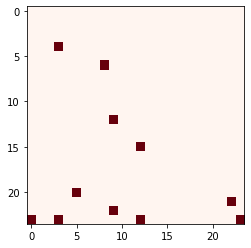

---  1  ---
input SDR:  SDR( 21 ) 3, 4, 5
Active SDR:  SDR( 576 ) 99, 152, 297, 372, 485, 526, 537, 552, 555, 564, 575


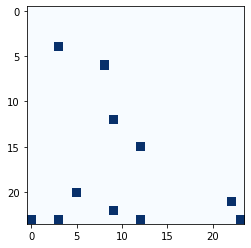

SDR( 576, 11 ) 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1672, 1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682, 3267, 3268, 3269, 3270, 3271, 3272, 3273, 3274, 3275, 3276, 3277, 4092, 4093, 4094, 4095, 4096, 4097, 4098, 4099, 4100, 4101, 4102, 5335, 5336, 5337, 5338, 5339, 5340, 5341, 5342, 5343, 5344, 5345, 5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795, 5796, 5907, 5908, 5909, 5910, 5911, 5912, 5913, 5914, 5915, 5916, 5917, 6072, 6073, 6074, 6075, 6076, 6077, 6078, 6079, 6080, 6081, 6082, 6105, 6106, 6107, 6108, 6109, 6110, 6111, 6112, 6113, 6114, 6115, 6204, 6205, 6206, 6207, 6208, 6209, 6210, 6211, 6212, 6213, 6214, 6325, 6326, 6327, 6328, 6329, 6330, 6331, 6332, 6333, 6334, 6335
SDR( 576, 11 ) 737, 1133, 2013, 4840, 5885, 5962, 5995, 6006, 6017, 6138, 6281, 6303
----------------------------------------------------------------------
Active sdr:  SDR( 576 ) 99, 152, 297, 372, 485, 526, 537, 552, 555, 564, 575
---------------------------

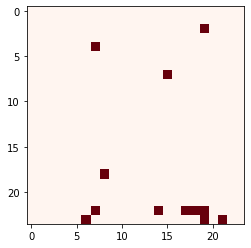

---  2  ---
input SDR:  SDR( 21 ) 6, 7, 8
Active SDR:  SDR( 576 ) 67, 103, 183, 440, 535, 542, 545, 546, 547, 558, 571


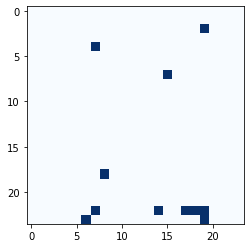

SDR( 576, 11 ) 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 4840, 4841, 4842, 4843, 4844, 4845, 4846, 4847, 4848, 4849, 4850, 5885, 5886, 5887, 5888, 5889, 5890, 5891, 5892, 5893, 5894, 5895, 5962, 5963, 5964, 5965, 5966, 5967, 5968, 5969, 5970, 5971, 5972, 5995, 5996, 5997, 5998, 5999, 6000, 6001, 6002, 6003, 6004, 6005, 6006, 6007, 6008, 6009, 6010, 6011, 6012, 6013, 6014, 6015, 6016, 6017, 6018, 6019, 6020, 6021, 6022, 6023, 6024, 6025, 6026, 6027, 6138, 6139, 6140, 6141, 6142, 6143, 6144, 6145, 6146, 6147, 6148, 6281, 6282, 6283, 6284, 6285, 6286, 6287, 6288, 6289, 6290, 6291
SDR( 576, 11 ) 605, 1914, 2794, 3146, 3443, 3740, 4070, 4554, 5643, 5984, 6215
----------------------------------------------------------------------
Active sdr:  SDR( 576 ) 67, 103, 183, 440, 535, 542, 545, 546, 547, 558, 571
--------------------------------------------

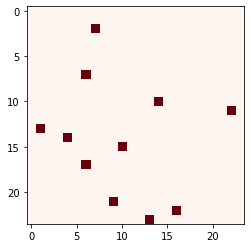

---  3  ---
input SDR:  SDR( 21 ) 9, 10, 11
Active SDR:  SDR( 576 ) 55, 174, 254, 286, 313, 340, 370, 414, 513, 544, 565


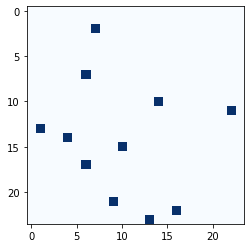

SDR( 576, 11 ) 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 3146, 3147, 3148, 3149, 3150, 3151, 3152, 3153, 3154, 3155, 3156, 3443, 3444, 3445, 3446, 3447, 3448, 3449, 3450, 3451, 3452, 3453, 3740, 3741, 3742, 3743, 3744, 3745, 3746, 3747, 3748, 3749, 3750, 4070, 4071, 4072, 4073, 4074, 4075, 4076, 4077, 4078, 4079, 4080, 4554, 4555, 4556, 4557, 4558, 4559, 4560, 4561, 4562, 4563, 4564, 5643, 5644, 5645, 5646, 5647, 5648, 5649, 5650, 5651, 5652, 5653, 5984, 5985, 5986, 5987, 5988, 5989, 5990, 5991, 5992, 5993, 5994, 6215, 6216, 6217, 6218, 6219, 6220, 6221, 6222, 6223, 6224, 6225
SDR( 576, 11 ) 429, 660, 759, 2321, 4202, 5599, 5753, 5940, 6073, 6116, 6304
----------------------------------------------------------------------
Active sdr:  SDR( 576 ) 55, 174, 254, 286, 313, 340, 370, 414, 513, 544, 565
----------------------------------------------

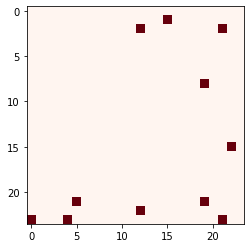

---  4  ---
input SDR:  SDR( 21 ) 12, 13, 14
Active SDR:  SDR( 576 ) 39, 60, 69, 211, 382, 509, 523, 540, 552, 556, 573


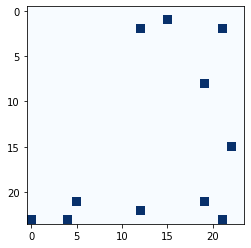

SDR( 576, 11 ) 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 2321, 2322, 2323, 2324, 2325, 2326, 2327, 2328, 2329, 2330, 2331, 4202, 4203, 4204, 4205, 4206, 4207, 4208, 4209, 4210, 4211, 4212, 5599, 5600, 5601, 5602, 5603, 5604, 5605, 5606, 5607, 5608, 5609, 5753, 5754, 5755, 5756, 5757, 5758, 5759, 5760, 5761, 5762, 5763, 5940, 5941, 5942, 5943, 5944, 5945, 5946, 5947, 5948, 5949, 5950, 6072, 6073, 6074, 6075, 6076, 6077, 6078, 6079, 6080, 6081, 6082, 6116, 6117, 6118, 6119, 6120, 6121, 6122, 6123, 6124, 6125, 6126, 6303, 6304, 6305, 6306, 6307, 6308, 6309, 6310, 6311, 6312, 6313
SDR( 576, 11 ) 781, 1320, 1859, 2266, 2398, 2981, 3432, 3444, 3696, 4631, 6305
----------------------------------------------------------------------
Active sdr:  SDR( 576 ) 39, 60, 69, 211, 382, 509, 523, 540, 552, 556, 573
--------------------------------------------------------------------

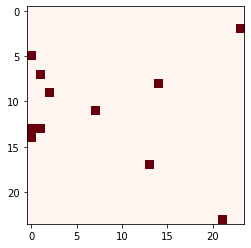

---  5  ---
input SDR:  SDR( 21 ) 15, 16, 17
Active SDR:  SDR( 576 ) 71, 120, 169, 206, 218, 271, 312, 313, 336, 421, 573


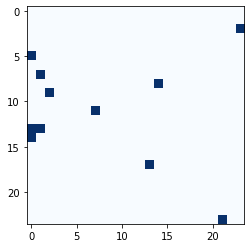

SDR( 576, 11 ) 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329, 1330, 1859, 1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 2266, 2267, 2268, 2269, 2270, 2271, 2272, 2273, 2274, 2275, 2276, 2398, 2399, 2400, 2401, 2402, 2403, 2404, 2405, 2406, 2407, 2408, 2981, 2982, 2983, 2984, 2985, 2986, 2987, 2988, 2989, 2990, 2991, 3432, 3433, 3434, 3435, 3436, 3437, 3438, 3439, 3440, 3441, 3442, 3443, 3444, 3445, 3446, 3447, 3448, 3449, 3450, 3451, 3452, 3453, 3696, 3697, 3698, 3699, 3700, 3701, 3702, 3703, 3704, 3705, 3706, 4631, 4632, 4633, 4634, 4635, 4636, 4637, 4638, 4639, 4640, 4641, 6303, 6304, 6305, 6306, 6307, 6308, 6309, 6310, 6311, 6312, 6313
SDR( 576, 11 ) 517, 1045, 1122, 1232, 2255, 2717, 3410, 3982, 4543, 5500, 6326
----------------------------------------------------------------------
Active sdr:  SDR( 576 ) 71, 120, 169, 206, 218, 271, 312, 313, 336, 421, 573
--------------------------------------------

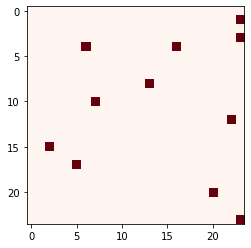

---  6  ---
input SDR:  SDR( 21 ) 18, 19, 20
Active SDR:  SDR( 576 ) 47, 95, 102, 112, 205, 247, 310, 362, 413, 500, 575


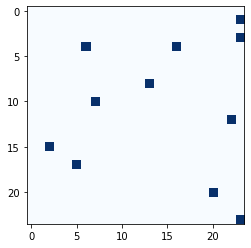

SDR( 576, 11 ) 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242, 2255, 2256, 2257, 2258, 2259, 2260, 2261, 2262, 2263, 2264, 2265, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 3410, 3411, 3412, 3413, 3414, 3415, 3416, 3417, 3418, 3419, 3420, 3982, 3983, 3984, 3985, 3986, 3987, 3988, 3989, 3990, 3991, 3992, 4543, 4544, 4545, 4546, 4547, 4548, 4549, 4550, 4551, 4552, 4553, 5500, 5501, 5502, 5503, 5504, 5505, 5506, 5507, 5508, 5509, 5510, 6325, 6326, 6327, 6328, 6329, 6330, 6331, 6332, 6333, 6334, 6335
SDR( 576, 11 ) 682, 1243, 1331, 2442, 2673, 3520, 4499, 4983, 5258, 6237, 6292
----------------------------------------------------------------------
Active sdr:  SDR( 576 ) 47, 95, 102, 112, 205, 247, 310, 362, 413, 500, 575
---------------------------------------------

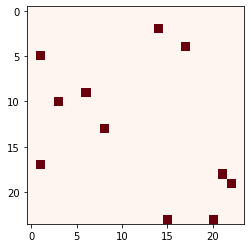

In [16]:
for i in range(len(pitchNames)):
    print("--- ", i ," ---")
    inputSDR = enc.encode(i)
    print("input SDR: ",inputSDR)
    sp.compute(inputSDR, False, activeSDR)
    print("Active SDR: ",activeSDR)
    
    sampleSDR=activeSDR.dense.reshape(24,24)
    plt.imshow(sampleSDR, cmap = "Blues")
    plt.pause(0.01)

    tm.reset()
    tm.compute( activeSDR, learn=False)
    tm.activateDendrites(True)
    activeColumnsIndices   = [tm.columnForCell(i) for i in tm.getActiveCells().sparse]
    predictedColumnIndices = [tm.columnForCell(i) for i in tm.getPredictiveCells().sparse]
    
    print(tm.getActiveCells())
    print(tm.getPredictiveCells())

    active_sdr = SDR( tm.numberOfColumns() )
    active_sdr.sparse  = np.array(sorted(set(activeColumnsIndices)))
    print("-"*70 )
    print("Active sdr: ", active_sdr)

    predict_sdr = SDR( tm.numberOfColumns() )
    predict_sdr.sparse  = np.array(sorted(set(predictedColumnIndices)))
    print("-"*70 )
    print("Predicted sdr: ",predict_sdr)

    print("-"*70 )
    print("PDF: ",clsr.infer( predict_sdr) )
    print("-"*70 )
    tm_predict = np.argmax( clsr.infer( predict_sdr) ) 
    print("predict index: ",tm_predict)
    print("-"*70 )
    print("predict label: ",pitchNames[tm_predict])

    print("")
    
    sampleSDR=predict_sdr.dense.reshape(24,24)
    plt.imshow(sampleSDR, cmap = "Reds")
    plt.pause(0.01)